# word2vec challenge #

The challenge is to improve the word2vec model that we developed in the previous notebook.

Read the original paper for inpiration and ideas to make the word2vec model better: [word2vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

Some ideas to improve:

* Train using the entire vocabulary/dataset
* Include an "unknown" token and split data into valdiation and test sets
* Implement negative sampling
* Implement more efficient versions of softmax
* experiment with different dimensionality reductions (TSNE, PCA) applied to your `W_h` matrix.
* anything else you can think of

Assessment of performance for this models is more open-ended. Submit your scatter plots of word embeddings in a notebook that explains what you implemented/achieved.

In [36]:
import tensorflow as tf
import re
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt

In [37]:
df = pd.read_csv('songdata.csv')
df['text'] = 'trats ' + df['text'] + ' dne' # start ("trats") and end ("dne") tokens

In [38]:
data = df['text'].str.cat(sep=' ').lower() # lowercase all strings
# data = ' '.join(word for word in data.split()) # remove punctuation
# punctuation = re.sub('\'', '', string.punctuation)
# data = re.sub('(['+punctuation+'])', r' \1', data)
data = ' '.join(word.strip(string.punctuation) for word in data.split()) # remove punctuation

In [44]:

print len(all_data_id), len(all_data_word), len(words)

112 112 98


In [62]:
from collections import Counter
num_chars = 1000 # up to 62532635
counts = Counter(data[0:num_chars].split(' ')) # using only the first 1000 characters in the string of lyrics
count_pairs = sorted(counts.items(), key=lambda x: (-x[1], x[0])) # sort first by incidence, then by alpha numeric key
words, word_count = list(zip(*count_pairs))
num_words = len(words)
word_to_id = dict(zip(words, range(num_words))) # get an ID for each word
id_to_word = dict(zip(range(num_words), words)) # get a word for each id
all_data_word = data[0:num_chars].split(' ') # using only the first 1000 characters in the string of lyrics
all_data_id = [word_to_id[word] for word in all_data_word]

In [69]:
thresh = 0.01
frequencies = np.zeros(num_words)
for word_id in all_data_id:
    frequencies[word_id] += 1
frequencies = np.divide(frequencies, num_words)
discard_probs = np.subtract(1, np.sqrt(np.divide(thresh,frequencies)))
# print discard_probs
# print frequencies

/Users/oshlern/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  


In [64]:
# n = range(len(all_data_word))
i = 0
while i < len(all_data_word):
    ind = all_data_id[i]
    if np.random.rand() < discard_probs[ind]:
        del all_data_word[i]
        del all_data_id[i]
    i += 1

In [65]:
C = 2
N = len(all_data_id)
train_data = np.zeros((C+1,N-2))
j=0
for i in xrange(1,N-1):
    train_data[:,j] = all_data_id[i-C/2:i+C/2+1]
    j += 1

V = len(word_to_id)
x_tr = np.zeros((N-2,V))
x_tr[range(N-2),train_data[1,:].astype(int)] = 1

y_tr = np.zeros((N-2,V)).astype(int)
y_tr[range(N-2),train_data[0,:].astype(int)] = 1
y_tr[range(N-2),train_data[2,:].astype(int)] = 1
print V, N

98 156


In [73]:
V = len(word_to_id)
H = 50
lr = 0.003

X = tf.placeholder("float", shape=[None,V])
y = tf.placeholder("int32", shape=[None,V])

W_h = tf.Variable(tf.random_normal((V,H), stddev = 0.01)) # mean=0.0
b_h = tf.Variable(tf.zeros((1,H)))

# we now do the forward pass until we obtain the scores
h1 = tf.matmul(X,W_h) + b_h
h2 = tf.layers.dense(h1,50,tf.nn.relu)
h3 = tf.layers.dense(h2,10,tf.nn.relu)
scores = tf.layers.dense(h3,V,tf.nn.sigmoid)
y_hat = tf.nn.softmax(scores)

loss_f = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=scores))
GD_step = tf.train.AdamOptimizer(lr).minimize(loss_f)



In [93]:
def get_batch(size=20):
    inds = np.random.choice(N-2, size, replace=False)
    x, y = x_tr[inds,:], y_tr[inds,:]
    return x, y

def train(sess, nepochs=25, batch_size=25, calc_loss=True, loss_freq=100):
#     print type(x_tr), type(y_tr)
    if calc_loss:
#         losses = np.ndarray(shape=(int(np.ceil(np.true_divide(nepochs, loss_freq)))), dtype=float)
        losses = np.ndarray(shape=(nepochs), dtype=float)
        for i in range(nepochs):
#             x, y = tf.train.batch([x_tr, y_tr], batch_size=batch_size)
#             sess.run(y)
#             x, y = x_tr, y_tr
            x_batch, y_batch = tf.train.batch([x_tr, y_tr], batch_size) #get_batch(size=batch_size)
            sess.run(GD_step, feed_dict={X: np.array(x_batch), y: np.array(y_batch)})#x_tr, y: y_tr})
            if i%loss_freq == 0:
                loss = sess.run(loss_f, feed_dict={X: x_tr, y: y_tr})
                losses[i] = loss
                print "epoch ", i, " loss ", loss
                if i != 0:
                    losses[i-loss_freq+1:i] = loss
        loss = sess.run(loss_f, feed_dict={X: x_tr, y: y_tr})
        losses[nepochs-loss_freq:] = loss
#         print "epoch ", nepochs, " loss ", loss
        return losses
    else:
         for i in range(nepochs):
            sess.run(GD_step, feed_dict={X: x_tr, y: y_tr})

def test():
    predicted_labels = sess.run(max_y_index, feed_dict={X: x_tr, y: y_tr})
    tr_acc = np.mean(predicted_labels == np.argmax(y_tr, axis = 1))
    print "The accuracy on the training set is: ", tr_acc
    return vl_acc

def graph(losses):
    %matplotlib notebook
    plt.plot(losses)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()
#     time.sleep(5)
#     plt.close()

In [94]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# you can loop over this to train over more than one epoch.
losses = train(sess, nepochs=50000, loss_freq=500)
graph(losses)

# If you want to obtain the accuracy of the network on the training set:
# final_loss = sess.run(loss, feed_dict={X: x_tr, y: y_tr})
# print "The final training loss is: ", final_loss

# save W_h to visualize the embeddings
# W_h = W_h.eval(session=sess)

sess.close()              

# The initial traning loss is around 9.17 (use as reference to assess training progress)
# how low could the loss go?

ValueError: setting an array element with a sequence.

<IPython.core.display.Javascript object>


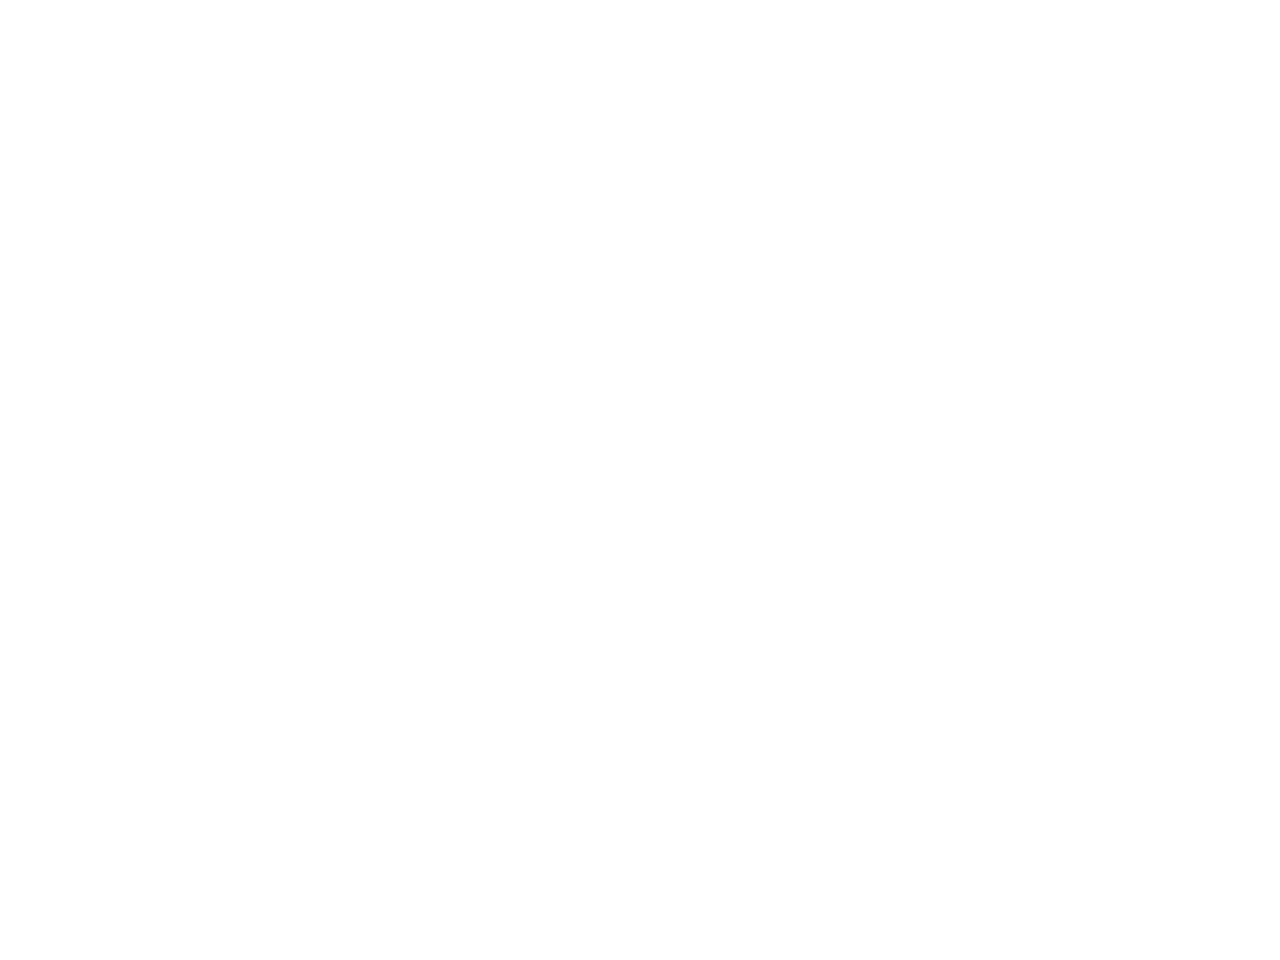

ValueError: setting an array element with a sequence.

In [39]:
%matplotlib notebook
for i in range(W_h.shape[0]):
    plt.scatter(W_h[i,0],W_h[i,1])
    plt.annotate(id_to_word[i],[W_h[i,0],W_h[i,1]])

In [10]:
print x_tr.shape, y_tr.shape

(208, 98) (208, 98)


In [11]:
print "a"

a
